In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [44]:
# Now unloading the tfrecords formatted files
def preprocess(tfrecord):
    
    # Setting up the landing pad of upcoming read protobufs
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parsing a single example protobuf from the file
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    
    # Getting the image portion of the protobuf
    image = tf.io.parse_tensor(example["image"], out_type=tf.float32)
    
    # Reshaping the image
    image = tf.reshape(image, shape=[224, 224, 3])
    
    # Returning the image and the label portion of the protobuf. The label portion is already saved as a int_64
    return image, example["label"]

# Expects a list of tfrecord file names and maps the above function to them while performing other prep and returning
# a tensorflow dataset
def load_tfrecord_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    # When a TFRecordDataset is read, it is a dataset that is still unparsed and in it's TFRecord form, just collected
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    
    # Caching the files from each of the filepaths
    if cache:
        dataset = dataset.cache()
        
    # Loading the shuffle buffer size
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    # Using the preprocess function to map(parse) the unparsed data into the instance (image, label)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    # Prefetch for faster processing one batch ahead
    return dataset.prefetch(1)

def get_filepaths(filename):
    datasetFile = open(filename, "r")
    fileList = datasetFile.read().splitlines()
    return fileList

In [45]:
# Loading the data from the tfrecords
train_files = get_filepaths("train_filepaths.txt")
valid_files = get_filepaths("valid_filepaths.txt")
test_files = get_filepaths("test_filepaths.txt")

train_dataset = load_tfrecord_dataset(train_files)
valid_dataset = load_tfrecord_dataset(valid_files)
test_dataset = load_tfrecord_dataset(test_files)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


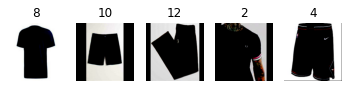

In [46]:
# Sanity check to make sure the images are still intact
for X, y in train_dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy())
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [54]:
# Building the top of the model (With Mobile Net)
n_classes = 37
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",
include_top=False, classes=n_classes)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [55]:
# Freezing the weights so I don't ruin the good lower layers
for layer in base_model.layers:
    layer.trainable = False

In [56]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), metrics=["accuracy"])

In [59]:
# Making sure I only get back the best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mobileNetClothing.h5", save_best_only=True)

In [60]:
model.fit(train_dataset, epochs=8, validation_data=valid_dataset, callbacks=[checkpoint_cb])

Epoch 1/8
443/443 [==============================] - 122s 272ms/step - loss: 1.0653 - accuracy: 0.6968 - val_loss: 0.6226 - val_accuracy: 0.8250


/home/ryuparish/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/8
443/443 [==============================] - 120s 272ms/step - loss: 0.4483 - accuracy: 0.8725 - val_loss: 0.4920 - val_accuracy: 0.8530
Epoch 3/8
443/443 [==============================] - 131s 295ms/step - loss: 0.3241 - accuracy: 0.9121 - val_loss: 0.4437 - val_accuracy: 0.8700
Epoch 4/8
443/443 [==============================] - 127s 288ms/step - loss: 0.2544 - accuracy: 0.9332 - val_loss: 0.4219 - val_accuracy: 0.8770
Epoch 5/8
443/443 [==============================] - 133s 299ms/step - loss: 0.2069 - accuracy: 0.9483 - val_loss: 0.4126 - val_accuracy: 0.8780
Epoch 6/8
443/443 [==============================] - 133s 301ms/step - loss: 0.1717 - accuracy: 0.9619 - val_loss: 0.4091 - val_accuracy: 0.8770
Epoch 7/8
443/443 [==============================] - 142s 321ms/step - loss: 0.1446 - accuracy: 0.9700 - val_loss: 0.4088 - val_accuracy: 0.8780
Epoch 8/8
443/443 [==============================] - 125s 281ms/step - loss: 0.1232 - accuracy: 0.9766 - val_loss: 0.4111 - val_ac

In [61]:
model.evaluate(test_dataset)

32/32 [==============================] - 8s 242ms/step - loss: 0.3889 - accuracy: 0.8860


[0.38886913657188416, 0.8859999775886536]